This notebook was downloaded from Kaggle with only one modification, in the pip install block, noted in the comment. The original notebook was created by csalexi: https://www.kaggle.com/csalexi

# Fine-tuning BERT using the Models feature!

In this notebook, I will very lightly adapting a tutorial from Tensorflow to show off how easy it is to import models using the Kaggle Models feature!

## First Steps: Selecting your models

  1. We can use the Notebook slide-out window on the right and navigate to the "Models" section, like so: 

  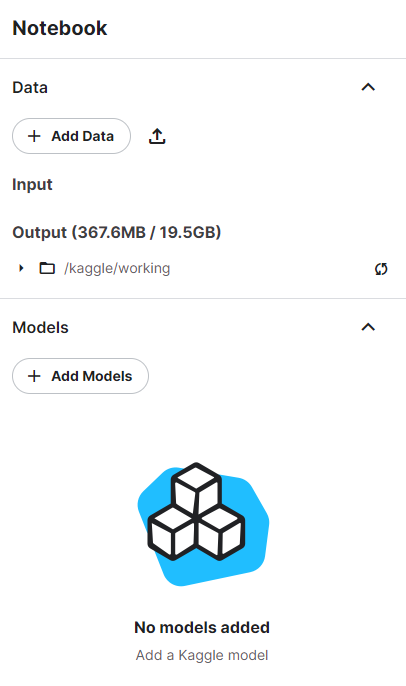

  2. Go ahead an click "**+ Add Models**"

  3. We'll want to type "bert" into the search bar, and click on "bert"!

  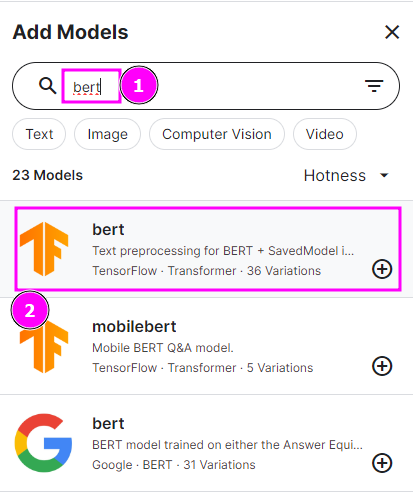
  
  4. Now, it's as simple as selecting the variation of BERT, and the version - once you've made your decision, go ahead an press "**+ Add Model**"
  
  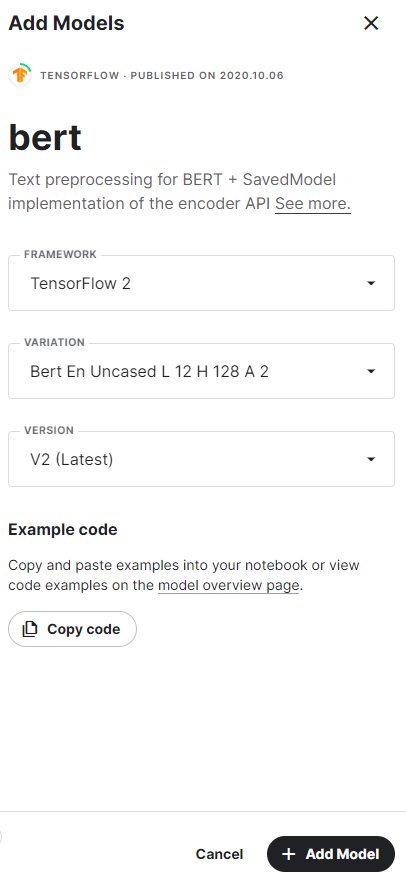
  
  5. After that we can add the preprocess model, just to show off all we can do with this feature!
  
  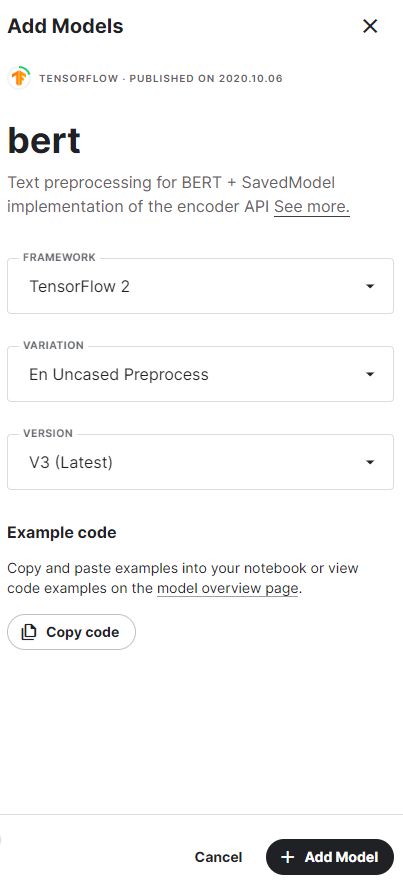
  

And that's it for this part!

## Checking for our local models

We can run the following cells to grab the paths to our local saved models!

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-128-a-2/2/saved_model.pb
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-128-a-2/2/keras_metadata.pb
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-128-a-2/2/assets/vocab.txt
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-128-a-2/2/variables/variables.index
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-128-a-2/2/variables/variables.data-00000-of-00001
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/saved_model.pb
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/keras_metadata.pb
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/assets/vocab.txt
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/variables/variables.index
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/variables/variables.data-00000-of-00001


## Setting things up for finetuning

First up, we'll be relying on a particular optimizer - more information is available in the tutorial this is based on! In order to be able to use it, we'll need to grab a dependency! 

After that, it's the usual imports!

### Getting [AdamW optimizer dependencies](https://github.com/tensorflow/models)

In [28]:
# changed from == to >=

!pip install -q tf-models-official>=2.11.0

### Imports

In [5]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

### Downloading the Dataset

In [6]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84125825/84125825 [==============================] - 10s 0us/step


### Setting up our datasets (train, valid, and test!)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


### Loading our preprocessing model!

Now we can simply point `tf.saved_model.load()` to our local path from above (be sure to point this at the `en-uncased-preprocess/VERSION_NUMBER/`  directory from above!

In [8]:
bert_preproc_model = tf.saved_model.load('/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/')

Let's verify the loaded model is working by processing some text!

In [9]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preproc_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Looking good!

### Loading BERT!

Now we can repeat the above process with the actual model! Make sure you use the correct filepath from above!

In [11]:
bert_model = tf.saved_model.load('/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-128-a-2/2/')

Again, let's just test to make sure it's working...

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Pooled Outputs Shape:(1, 128)
Pooled Outputs Values:[-0.6506855   0.9876484   0.06768849 -0.9012128  -0.9957721   0.7920224
 -0.48613214  0.13377686  0.9904963   0.09751623 -0.8468634   0.95103794]
Sequence Outputs Shape:(1, 128, 128)
Sequence Outputs Values:[[-1.0109123   0.06332098  0.29298124 ...  0.01315242  0.9920455
   0.31227148]
 [-1.3266462  -0.6547252   0.2348194  ...  0.2625032   1.3311368
   0.29998574]
 [-2.141977    0.18019868  0.93737507 ...  0.14259237  0.2822732
  -0.6736379 ]
 ...
 [-0.18610585 -1.0546873   0.6742333  ...  0.4814109   1.0200245
   0.9911772 ]
 [-0.44571394 -0.7939286   0.40449896 ... -0.31669122  0.62027395
   1.3922361 ]
 [-1.1939578  -1.1515343  -0.27067983 ...  0.343368    0.86735785
   0.62001485]]


### Defining, building, and compiling our model for finetuning!

The most important part of this process is to ensure that you are wrapping the loaded model in a layer that can call it.

Here I've used `hub.KerasLayer()`, we need to do this to make sure that our model can be used in the `tf.keras.Model()`.

Also pay attention to the fact that we're passing `trainable=True` along with our`bert_model`, this lets us train the base model alongside our classifier!

Otherwise we're just adding a classifier head to the pretrained BERT model.

In [15]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(bert_preproc_model, name = 'preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(bert_model, trainable=True, name="Bert_encoder")
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

Now we build the classifier and pass a sample through it!

In [16]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.44386086]], shape=(1, 1), dtype=float32)


Let's take a peak at our model summary!

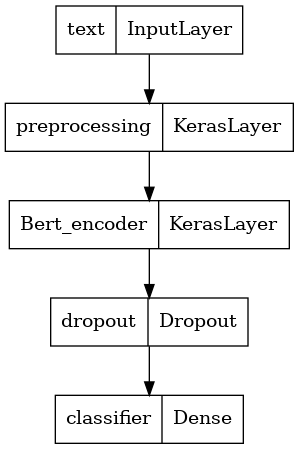

In [17]:
tf.keras.utils.plot_model(classifier_model)

Now we can set up our loss and metrics.

In [20]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

We'll define some hyper-parameters, and set up our AdamW optimizer here.

In [22]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

Now it's time to compile!

In [24]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

### Finetuning BERT!

And here we are, finally ready to finetune BERT!

In [25]:
print(f'Training model with Bert!')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with Bert!
Epoch 1/5
625/625 [==============================] - 104s 140ms/step - loss: 0.5646 - binary_accuracy: 0.6788 - val_loss: 0.4397 - val_binary_accuracy: 0.7922
Epoch 2/5
625/625 [==============================] - 86s 137ms/step - loss: 0.4241 - binary_accuracy: 0.7967 - val_loss: 0.4086 - val_binary_accuracy: 0.8138
Epoch 3/5
625/625 [==============================] - 85s 136ms/step - loss: 0.3798 - binary_accuracy: 0.8240 - val_loss: 0.3980 - val_binary_accuracy: 0.8210
Epoch 4/5
625/625 [==============================] - 84s 135ms/step - loss: 0.3485 - binary_accuracy: 0.8426 - val_loss: 0.3956 - val_binary_accuracy: 0.8284
Epoch 5/5
625/625 [==============================] - 84s 134ms/step - loss: 0.3333 - binary_accuracy: 0.8519 - val_loss: 0.4046 - val_binary_accuracy: 0.8250


### Evaluate the finetuned model

And look at that, we see our model achieves `~0.83` binary accuracy! Not so bad - and definitely an improvement over the original!

In [26]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 64s 82ms/step - loss: 0.3939 - binary_accuracy: 0.8298
Loss: 0.39390018582344055
Accuracy: 0.829800009727478


## Conclusion

And there we have it, quick fine tuning with Kaggle Models!

# Credits

This tutorial is adapted from [this](https://www.tensorflow.org/text/tutorials/classify_text_with_bert) tutorial from TensowFlow!

It was licensed under the [Creative Commons Attribution 4.0 License](https://creativecommons.org/licenses/by/4.0/), and the code snippets are licensed under [APACHE LICENSE, VERSION 2.0](https://www.apache.org/licenses/LICENSE-2.0)